<div class="frontmatter text-center">
<h1>Geospatial Data Science</h1>
<h2>Lecture 4: Spatial weights</h2>
<h3>IT University of Copenhagen, Spring 2022</h3>
<h3>Instructor: Michael Szell</h3>
</div>

# Source
This notebook was adapted from:
* A course on Geographic Data Science: https://darribas.org/gds_course/content/bE/lab_E.html

在本节中，我们将学习空间分析中关键部分之一的来龙去脉：空间权重矩阵。这些是结构化的数字集，用于形式化数据集中观测值之间的地理关系。本质上，给定地理的空间权重矩阵是维度$N$ 乘以 $N$ 的正定矩阵，其中 $N$ 是观测值的总数：

$
W = \left(\begin{array}{cccc}
0 & w_{12} & \dots & w_{1N} \\
w_{21} & \ddots & w_{ij} & \vdots \\
\vdots & w_{ji} & 0 & \vdots \\
w_{N1} & \dots & \dots & 0 
\end{array} \right)
$

其中，每个像元 $w_{ij}$ 包含一个值，该值表示观测值 $i$ 和 $j$ 之间的空间接触或交互程度。在这种情况下，一个基本概念是*邻居*和*邻里*。按照惯例，对角线 （$w_{ii}$） 中的元素设置为零。给定观测值 $i$ 的 *邻居* 是与 $i$ 有一定程度联系的另一个观测值。就 $W$ 而言，如果 $w_{ij} > 0$，则 $i$ 和 $j$ 是邻居。按照这个逻辑，$i$的邻域将是系统中与其有一定联系的观测值集，或者是权重大于零的观测值。

有几种方法可以创建这样的矩阵，还有更多的方法可以转换它们，以便它们包含准确的表示，与我们理解系统元素之间的空间相互作用的方式一致。在本次会议中，我们将介绍最常用的方法，并展示如何使用`PySAL`计算它们。

In [1]:
import seaborn as sns
import pandas as pd
from pysal.lib import weights
from libpysal.io import open as psopen
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

d:\work\miniconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Data

在本教程中，我们将使用利物浦小区域(或 [下层超级输出区域，LSOA]，https://en.wikipedia.org/wiki/ONS_coding_system))的数据集。

In [2]:
# Read the file in
db = gpd.read_file("files/liv_lsoas.gpkg")
# Index table on the LSOA ID
db = db.set_index("LSOA11CD", drop=False)
# Display summary
db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 298 entries, E01006512 to E01033768
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   LSOA11CD  298 non-null    object  
 1   MSOA11CD  298 non-null    object  
 2   geometry  298 non-null    geometry
dtypes: geometry(1), object(2)
memory usage: 9.3+ KB


<AxesSubplot:>

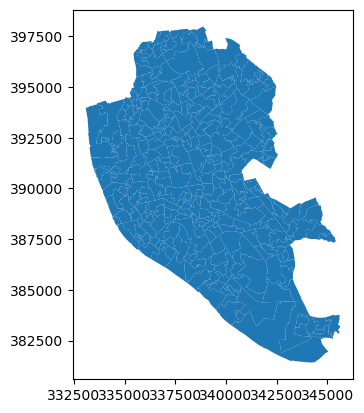

In [3]:
db.plot()

## 在`PySAL`中构建空间权重

### Contiguity

邻接权重矩阵通过公共边界的存在来定义空间连接。这使得它直接适合与多边形一起使用：如果两个多边形在某种程度上共享边界，则在这些权重下，它们将被标记为相邻面。确切地说，他们需要分享多少是我们将要学习的两种方法的不同之处：queen 和 rook。

* **Queen**

根据queen标准，两个观测值只需要共享其边界的涡旋（单个点）即可被视为邻居。在这些原则下构造权重矩阵可以通过运行以下命令来完成：

In [4]:
w_queen = weights.Queen.from_dataframe(db, idVariable="LSOA11CD")
w_queen

上面的命令创建一个类`W`的对象`w_queen`。这是空间权重矩阵存储在`PySAL`中的格式。默认情况下，权重生成器（`Queen.from_dataframe`）将使用表格的索引，这很有用，因此我们可以轻松地使所有内容保持一致。

可以查询“W”对象以查找它包含的邻接关系。例如，如果我们想知道谁是观察点 `E01006690` 的邻居：

In [5]:
w_queen['E01006690']

{'E01006691': 1.0,
 'E01006720': 1.0,
 'E01006759': 1.0,
 'E01033763': 1.0,
 'E01006697': 1.0,
 'E01006695': 1.0,
 'E01006692': 1.0}

这将返回一个 Python 字典，其中包含每个邻居的 ID 代码作为键，以及它们作为值分配的权重。由于我们正在查看原始的queen连续矩阵，因此每个邻居的权重为1。如果我们想访问特定邻居的权重，例如`E01006691`，我们可以进行递归查询：

In [6]:
w_queen['E01006690']['E01006691']

1.0

`W`对象还具有直接方法，可以为给定观测值提供所有邻居或其权重的列表。这要归功于`邻居`和`权重`属性：

In [7]:
w_queen.neighbors['E01006690']

['E01006691',
 'E01006720',
 'E01006759',
 'E01033763',
 'E01006697',
 'E01006695',
 'E01006692']

In [8]:
w_queen.weights['E01006690']

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

创建后，`W`对象可以提供有关矩阵的大量信息，超出人们期望的基本属性。我们可以通过属性`cardinalities`直接访问每个观测值的邻居数量。例如，要了解观测值`E01006524`有多少个邻居：

In [9]:
w_queen.cardinalities['E01006524']

6

由于`cardinalities`是一个字典，因此可以直接将其转换为`Series`对象：

In [10]:
queen_card = pd.Series(w_queen.cardinalities)
queen_card.head()

E01006512    6
E01006513    9
E01006514    5
E01006515    8
E01006518    5
dtype: int64

例如，这允许访问快速绘图，这对于获得一般社区大小的概述非常方便：

C:\Users\24365\AppData\Local\Temp\ipykernel_24100\3924685140.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(queen_card, bins=10)


<AxesSubplot:ylabel='Density'>

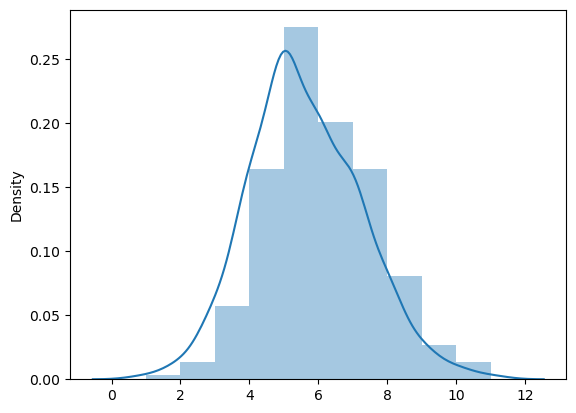

In [11]:
sns.distplot(queen_card, bins=10)

上图显示了大多数观测值如何具有大约五个相邻值，但周围存在一些差异。分布似乎也遵循对称形式，其中与平均值的偏差几乎均匀地出现在较高和较低的值中。

有关矩阵中包含的空间关系的一些附加信息也很容易从“W”对象中获得。让我们来看看其中的一些：

In [12]:
# Number of observations
w_queen.n

298

In [13]:
# Average number of neighbors
w_queen.mean_neighbors

5.617449664429531

In [14]:
# Min number of neighbors
w_queen.min_neighbors

1

In [15]:
# Max number of neighbors
w_queen.max_neighbors

11

In [16]:
# Islands (observations disconnected)
w_queen.islands

[]

In [17]:
# Order of IDs (first five only in this case)
w_queen.id_order[:5]

['E01006512', 'E01006513', 'E01006514', 'E01006515', 'E01006518']

可以通过其他方式直观地探索空间权重矩阵。例如，我们可以选择一个观察值，并在其邻域的上下文中对其进行可视化。下图通过放大 LSOA `E01006690` 的周围环境并显示其多边形及其相邻多边形来做到这一点：

(lab_E:queen_zoom)=

C:\Users\24365\AppData\Local\Temp\ipykernel_24100\266091606.py:12: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  neis = db.loc[w_queen['E01006690'], :]


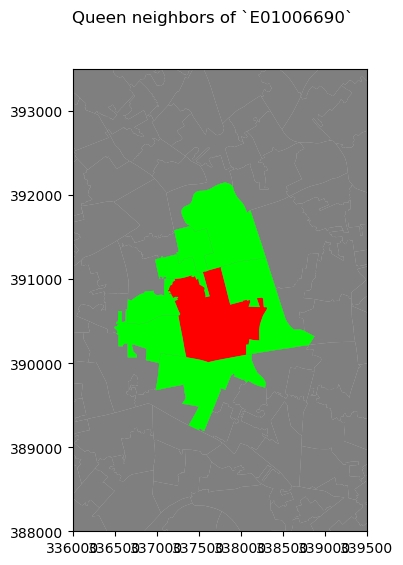

In [18]:
# Setup figure
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot base layer of polygons
db.plot(ax=ax, facecolor='k', linewidth=1, alpha=0.5)
# Select focal polygon
# NOTE we pass both the area code and the column name
#      (`geometry`) within brackets!!!
focus = db.loc[['E01006690'], ['geometry']]
# Plot focal polygon
focus.plot(facecolor='red', alpha=1, linewidth=1, ax=ax)
# Plot neighbors
neis = db.loc[w_queen['E01006690'], :]
neis.plot(ax=ax, facecolor='lime', linewidth=1)
# Title
f.suptitle("Queen neighbors of `E01006690`")
# Style and display on screen
ax.set_ylim(388000, 393500)
ax.set_xlim(336000, 339500)
plt.show()

请注意该图是如何逐渐构建的，从底图（L.4-5）到焦点（L.9），再到其邻域（L.11-13）。绘制整个图形后，我们放大感兴趣的区域（L.19-20）。

* **Rook**

Rook contiguity与Queen Contiguity相似，并且在许多方面被Queen Contiguity所取代。但是，由于它有时会出现在文献中，因此了解它是有用的。主要思想是相同的：如果两个观测值共享某些边界线，则它们是相邻的。然而，在 rook 的情况下，仅仅共享一个点是不够的，它至少需要是他们边界的一部分。在大多数应用情况下，这些差异通常归结为地理编码的完成方式，但在某些情况下，例如当我们使用栅格数据或格网时，这种方法可能会有更大的实质性差异，因此更有意义。

从技术角度来看，构造 rook 矩阵非常相似：

In [19]:
w_rook = weights.Rook.from_dataframe(db)
w_rook

输出的类型与以前相同，一个`W`对象，可以以与任何其他对象非常相同的方式进行查询和使用。

### Distance

基于距离的矩阵将权重分配给每对观测值，作为它们彼此相距多远的函数。如何将其转换为实际权重因类型和变体而异，但它们都认为，两个观测值被分配一些权重的最终原因是由于它们之间的距离。

* **K-Nearest Neighbors**

定义权重的一种方法是将给定观测值与集合的其余观测值之间的距离，对它们进行排名，并将最接近的$k$视为邻居。这正是$k$-最近邻（KNN）标准所做的。

要计算 KNN 权重，我们可以使用与以前类似的函数，并从 shapefile 导出它们：

In [20]:
knn5 = weights.KNN.from_dataframe(db, k=5)
knn5

请注意我们需要如何使用参数 'k' 指定我们要考虑的最近邻居的数量。由于它是我们正在传递的多边形形状文件，因此该函数将自动计算质心以得出观测值之间的距离。或者，我们可以以数组的形式提供点，以这种方式跳过文件在磁盘上的依赖关系：

In [21]:
# Extract centroids
cents = db.centroid
# Extract coordinates into an array
pts = pd.DataFrame(
    {"X": cents.x, "Y": cents.y}
).values
# Compute KNN weights
knn5_from_pts = weights.KNN.from_array(pts, k=5)
knn5_from_pts

* **Distance band**
 
构建基于距离的空间权重矩阵的另一种方法是绘制某个特定半径的圆，并考虑落在该圆内的每个观测值的邻居。该技术有两种主要变体：二进制和连续。在前一个中，每个邻居都被赋予一个权重，而在第二个中，权重可以通过到感兴趣观察的距离进一步调整。

要在 `PySAL` 中计算二进制距离矩阵，我们可以使用以下命令：

In [22]:
w_dist1kmB = weights.DistanceBand.from_dataframe(db, 1000)

d:\work\miniconda3\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


这将创建一个二进制矩阵，该矩阵考虑观测值的相邻要素，其质心距离此类观测值的质心小于 1，000 米 （1Km）。例如，检查多边形 `E01006690` 的邻域：

In [23]:
w_dist1kmB['E01006690']

{'E01006691': 1.0,
 'E01006692': 1.0,
 'E01006695': 1.0,
 'E01006697': 1.0,
 'E01006720': 1.0,
 'E01006725': 1.0,
 'E01006726': 1.0,
 'E01033763': 1.0}

请注意，指定距离的单位直接取决于投影空间数据的 CRS，这与权重构建无关，但可能会显著影响权重。回想一下如何检查`GeoDataFrame`的 CRS：

In [24]:
db.crs

<Projected CRS: PROJCS["Transverse_Mercator",GEOGCS["GCS_OSGB 1936 ...>
Name: Transverse_Mercator
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Transverse Mercator
Datum: OSGB 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

在这种情况下，您可以看到单位以米 （`m`） 表示，因此我们将 1 公里半径的圆圈的阈值设置为 1，000。

上述权重的扩展是通过根据它们与感兴趣观测值的距离为特定半径的圈内的不同邻居分配不同的权重来引入更多详细信息。例如，我们可以考虑将观测值 $i$ 和 $j$ 之间的距离的倒数指定为 $w_{ij}$。这可以使用以下命令进行计算：

In [25]:
w_dist1kmC = weights.DistanceBand.from_dataframe(db, 1000, binary=False)

d:\work\miniconda3\lib\site-packages\scipy\sparse\data.py:117: RuntimeWarning: divide by zero encountered in reciprocal
  return self._with_data(data ** n)


在`w_dist1kmC`中，1公里圆圈内的每个观测值都被分配了一个权重，等于两者之间的反距离：

$$
w_{ij} = \dfrac{1}{d_{ij}}
$$

这样，$i$ 和 $j$ 彼此之间的距离越远，权重就越小 $w_{ij}$ 就越小。

将二元邻域与 `E01006690` 的连续邻域进行对比：

In [26]:
w_dist1kmC['E01006690']

{'E01006691': 0.001320115452290246,
 'E01006692': 0.0016898106255168294,
 'E01006695': 0.001120923796462639,
 'E01006697': 0.001403469553911711,
 'E01006720': 0.0013390451319917913,
 'E01006725': 0.001009044334260805,
 'E01006726': 0.0010528395831202145,
 'E01033763': 0.0012983249272553688}

遵循这种通过距离获得更详细的权重的逻辑，很容易进一步将其视为数据集中的其他所有人作为邻居，然后其权重将通过上面显示的距离效应进行调制。 然而，尽管在概念上是正确的，但这种方法并不总是计算量最大或最实用的方法。 由于空间权重矩阵的性质，特别是因为它们的大小为 $N$ x $N$，它们可以变得非常大。 解决这个问题的一种方法是确保它们保持相当*稀疏*（有很多零）。 在连续性或 KNN 的情况下，通常可以通过构造来确保稀疏性，但是对于反距离，需要强加稀疏性，否则矩阵可能完全密集（除对角线外没有零值）。 实际上，通常所做的是施加一个距离阈值，超过该距离阈值则不分配权重，并且假定交互不存在。 除了在计算上可行和可扩展之外，这种方法的结果通常与完全“密集”的结果没有太大区别，因为进一步观察中包含的附加信息由于它们收到的权重很小而几乎被忽略。 在这种情况下，一个常用的阈值（虽然并不总是最好的）是使每个观察值至少有一个邻居。

这样的阈值可以计算如下：

In [27]:
min_thr = weights.min_threshold_distance(pts)
min_thr

939.7373992113434

然后可用于计算反距离权重矩阵：

In [28]:
w_min_dist = weights.DistanceBand.from_dataframe(db, min_thr, binary=False)

### Block weights

块权重连接数据集中的每个观察值，这些观察值属于事先提供的列表中的同一类别。 通常，此列表与地理和观测位置有某种关系，但从技术上讲，创建块权重所需的只是一个成员列表。 在此类权重中，相邻观测值（同一组中的观测值）的权重为 1，其余的权重为 0。

在此示例中，我们将构建一个空间权重矩阵，将每个 LSOA 与同一 MSOA 中的所有其他矩阵连接起来。 查看每个 LSOA 的 MSOA 代码是如何表示的：

In [29]:
db.head()

,LSOA11CD,MSOA11CD,geometry
LSOA11CD,,,
E01006512,E01006512,E02001377,"POLYGON ((336103.358 389628.580, 336103.416 38..."
E01006513,E01006513,E02006932,"POLYGON ((335173.781 389691.538, 335169.798 38..."
E01006514,E01006514,E02001383,"POLYGON ((335495.676 389697.267, 335495.444 38..."
E01006515,E01006515,E02001383,"POLYGON ((334953.001 389029.000, 334951.000 38..."
E01006518,E01006518,E02001390,"POLYGON ((335354.015 388601.947, 335354.000 38..."


要构建一个将同一 MSOA 中的所有 LSOA 作为邻居连接的块空间权重矩阵，我们只需要代码映射。 使用`PySAL`，这是一项单行任务：

In [30]:
w_block = weights.block_weights(db['MSOA11CD'])

d:\work\miniconda3\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 61 disconnected components.
  warnings.warn(message)


在这种情况下，`PySAL` 不允许像上面那样传递参数 `idVariable`。 结果，观察结果以列表中的占据顺序命名：

In [31]:
w_block[0]

{218: 1.0, 219: 1.0, 220: 1.0, 292: 1.0}

第一个元素是观测值 218、129、220 和 292 的邻居，它们的权重都为 1。但是，可以使用附加方法`remap_ids`来纠正此问题：

In [32]:
w_block.remap_ids(db.index)

现在，如果您尝试 `w_bloc[0]`，它将返回一个错误。 但是，如果您通过 LSOA id 查询观察的邻居，它将起作用：

In [33]:
w_block['E01006512']

{'E01006747': 1.0, 'E01006748': 1.0, 'E01006751': 1.0, 'E01033763': 1.0}

## 标准化`W`矩阵

在许多空间分析技术的上下文中，具有原始值的空间权重矩阵（例如二进制情况下的 1 和 0）并不总是最适合分析的矩阵，需要进行某种转换。 这意味着修改每个权重，使它们符合某些规则。 `PySAL` 将转换直接嵌入到 `W` 对象中，因此可以检查对象的状态并对其进行修改。

考虑原始queen权重，观察“E01006690”：

In [34]:
w_queen['E01006690']

{'E01006691': 1.0,
 'E01006720': 1.0,
 'E01006759': 1.0,
 'E01033763': 1.0,
 'E01006697': 1.0,
 'E01006695': 1.0,
 'E01006692': 1.0}

由于它是连续的，每个邻居都得到一个，其余的权重为零。 我们可以通过调用参数 `transform` 来检查对象 `w_queen` 是否已经被转换：

In [35]:
w_queen.transform

'O'

其中 `O` 代表“原始”，因此尚未应用任何转换。 如果我们想应用基于行的转换，矩阵的每一行总和为 1，我们修改 transform 属性如下：

In [36]:
w_queen.transform = 'R'

现在我们可以检查与上面相同的观察的权重，发现它们已被修改：

In [37]:
w_queen['E01006690']

{'E01006691': 0.14285714285714285,
 'E01006720': 0.14285714285714285,
 'E01006759': 0.14285714285714285,
 'E01033763': 0.14285714285714285,
 'E01006697': 0.14285714285714285,
 'E01006695': 0.14285714285714285,
 'E01006692': 0.14285714285714285}

除了精度问题，所有邻居的权重总和为 1：

In [38]:
pd.Series(w_queen['E01006690']).sum()

0.9999999999999998

将对象返回到其原始状态涉及将“transform”分配回原始状态：

In [39]:
w_queen.transform = 'O'

In [40]:
w_queen['E01006690']

{'E01006691': 1.0,
 'E01006720': 1.0,
 'E01006759': 1.0,
 'E01033763': 1.0,
 'E01006697': 1.0,
 'E01006695': 1.0,
 'E01006692': 1.0}

`PySAL` 支持以下转换：

* `O`: original，将对象返回到初始状态。
* `B`：二进制，每个邻居都分配了一个权重。
* `R`：行，给定观察的所有邻居加起来为一个。
* `V`：方差稳定，所有权重的总和被限制为观察的数量。

## 在 `PySAL` 中读写空间权重

有时，如果数据集非常详细或很大，则构建给定地理空间权重矩阵的成本可能很高，而且尽管在“PySAL”代码中进行了优化，但计算时间可能会很快失控。 在这些情况下，不必在每次需要重新运行分析时都从头开始重新构建矩阵是很有用的。 在这种情况下，一个有用的解决方案是构建一次矩阵，并将其保存到一个文件中，如果需要，可以在以后重新加载它。

`PySAL` 有一种通用方法，可以使用命令 `open` 将任何类型的 `W` 对象写入文件。 我们需要事先自己决定的唯一因素是文件的格式。 尽管有多种格式可以存储空间权重矩阵，但我们将重点关注两种最常用的格式：

* **`.gal`** 用于连续权重的文件

可以使用以下命令将邻接空间权重保存到 .gal 文件中：

In [41]:
# Open file to write into
fo = psopen('imd_queen.gal', 'w')
# Write the matrix into the file
fo.write(w_queen)
# Close the file
fo.close()

该过程由以下三个步骤组成：

1. 打开一个目标文件用于“w”矩阵，因此是“w”参数。 在这种情况下，如果文件 imd_queen.gal 已经存在，它将被覆盖，所以要小心。
1. 将 `W` 对象写入文件。
1. 关闭文件。 这一点很重要，因为在此阶段会将一些附加信息写入文件，因此未能关闭文件可能会产生意想不到的后果。

写入文件后，可以使用以下命令将其读回内存：

In [42]:
w_queen2 = psopen('imd_queen.gal', 'r').read()
w_queen2

请注意我们现在如何使用 `r` 而不是 `w` ，因为我们正在读取文件，还要注意我们如何打开文件，并在同一行中直接调用 `read()` 。

* **`.gwt`** 文件用于基于距离的权重。

与上述过程非常相似的过程可用于读取和写入基于距离的权重。 唯一的区别是指定了正确的文件格式，在本例中为“.gwt”。 所以，如果我们想将 `w_dist1km` 写入文件，我们将运行：

In [43]:
# Open file
fo = psopen('imd_dist1km.gwt', 'w')
# Write matrix into the file
fo.write(w_dist1kmC)
# Close file
fo.close()

如果我们想读回文件，我们需要做的就是：

In [44]:
w_dist1km2 = psopen('imd_dist1km.gwt', 'r').read()

d:\work\miniconda3\lib\site-packages\libpysal\io\iohandlers\gwt.py:204: RuntimeWarning: DBF relating to GWT was not found, proceeding with unordered string IDs.
  warn(msg, RuntimeWarning)
d:\work\miniconda3\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


请注意，在这种情况下，您可能会收到一条警告，提醒您没有与该文件相关的“DBF”。 这是因为，默认情况下，`PySAL` 从 shapefile 中获取 `.gwt` 中的观察顺序。 如果未提供，“PySAL”无法完全确定所有元素，因此生成的“W”可能不完整（例如，岛屿可能会丢失）。 为了完全完成文件的读取，我们可以像上面看到的那样重新映射 ids：

In [45]:
w_dist1km2.remap_ids(db.index)

## 空间滞后

空间权重矩阵最直接的应用之一是所谓的*空间滞后*。 给定变量的空间滞后是空间权重矩阵和变量本身的乘积：

$$
Y_{sl} = W Y
$$

其中 $Y$ 是一个包含变量值的 Nx1 向量。 回想一下，矩阵和向量的乘积等于给定行的结果值的逐列元素乘法之和。 在空间滞后方面：

$$
y_{sl-i} = \displaystyle \sum_j w_{ij} y_j
$$

如果我们使用行标准化的权重，$w_{ij}$ 就变成了 0 和 1 之间的比例，而 $y_{sl-i}$ 可以看作是 $Y$ 在 $i$ 附近的平均值 .

对于此说明，我们将使用每个多边形的面积作为感兴趣的变量。 为了让事情变得更好，我们将保留该区域的日志而不是原始测量值。 因此，让我们为它创建一个列：

In [46]:
db["area"] = np.log(db.area)

空间滞后是许多空间分析技术的关键要素，正如我们稍后将看到的那样，它在`PySAL`中得到完全支持。 要计算给定变量的空间滞后，例如`area`：

In [47]:
# Row-standardize the queen matrix
w_queen.transform = 'R'
# Compute spatial lag of `area`
w_queen_score = weights.lag_spatial(w_queen, db["area"])
# Print the first five elements
w_queen_score[:5]

array([12.40660189, 12.54225296, 12.28284814, 12.61675295, 12.55042815])

第 4 行包含实际计算，它在 `PySAL` 中进行了高度优化。 请注意，尽管传入了一个 `pd.Series` 对象，但输出是一个 `numpy` 数组。 然而，这可以直接添加到表 db 中：

In [48]:
db['w_area'] = w_queen_score

## Moran Plot

Moran 图是开始探索空间自相关概念的图形方式，是空间权重矩阵和空间滞后的良好应用。 从本质上讲，它是一个标准的散点图，其中给定变量（例如“区域”）针对*其自身的*空间滞后进行绘制。 通常，添加一条拟合线以包含更多信息：

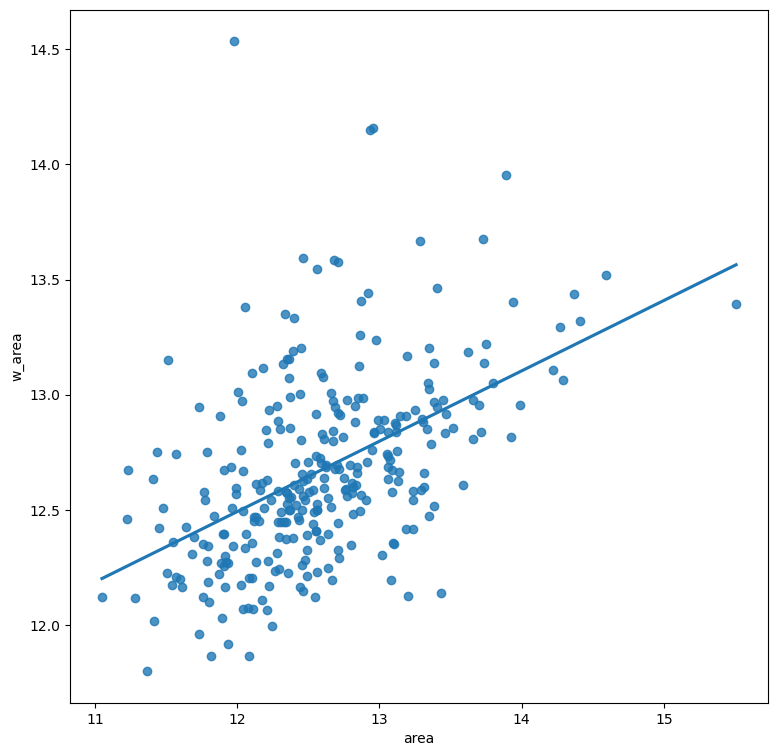

In [49]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x="area", y="w_area", data=db, ci=None)
# Display
plt.show()

为了轻松比较不同的散点图和发现离群值观察，通常的做法是在计算其空间滞后并绘制之前对变量的值进行标准化。 这可以通过减去平均值并将结果除以标准差来完成：

$$
z_i = \dfrac{y - \bar{y}}{\sigma_y}
$$

其中 $z_i$ 是 $y_i$ 的标准化版本，$\bar{y}$ 是变量的平均值，$\sigma$ 是它的标准差。

创建一个标准化的莫兰图意味着平均值在图中居中（因为它们在标准化时为零）并且分散度以标准差表示，大于或小于两个标准差的值的经验法则是*离群值*。 标准化的莫兰图还将空间划分为代表不同情况的四个象限：

1. 高-高 (*HH*)：高于平均值的值被高于平均值的值包围。
1. 低-低 (*LL*)：低于平均值的值被低于平均值的值包围。
1. 高-低 (*HL*)：高于平均值的值被低于平均值的值包围。
1. 低-高 (*LH*)：低于平均值的值被高于平均值的值包围。

一旦在后续块中适当引入空间自相关，将进一步探讨这些问题。

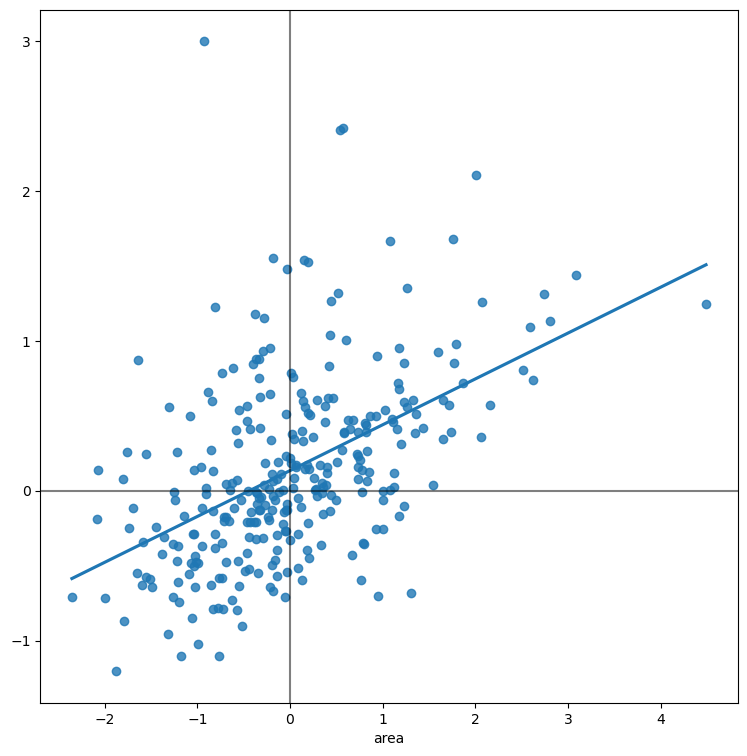

In [50]:
# Standardize the area
std_db = (db['area'] - db['area'].mean()) / db['area'].std()
# Compute the spatial lag of the standardized version and save is as a 
# Series indexed as the original variable
std_w_db = pd.Series(
    weights.lag_spatial(w_queen, std_db), index=std_db.index
)
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x=std_db, y=std_w_db, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Display
plt.show()